# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### Repositorio: 

## Exploración de datos y Procesamiento del Lenguaje Natural

Primero importo lo necesario para todo el proyecto:

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
import re
from sklearn.naive_bayes import GaussianNB
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Importare el dataset de dev para poder hacer la exploracion de los datos, elegi este data set por cuestion de procesamiento y la velocidad de los modelos.

In [2]:
dataset = pd.read_json('C:/Users/Usuario/Documents/DATA SCIENCE/DATA SETS/dataset_amazon/dataset_es_dev.json', lines= True)
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


Las columnas de id no me estan aportando informacion que considere util ya que en lo general son distintos productos o usuarios que realizan la reseña por lo tanto procedere a eliminarlas:

In [3]:
dataset = dataset.drop(columns=['review_id','product_id','reviewer_id'])

In [4]:
dataset['language'].value_counts()

es    5000
Name: language, dtype: int64

Como en esta columna se tiene un unico valor, Español, no aporta informacion por lo que tambien la eliminaré:

In [5]:
dataset = dataset.drop(columns=['language'])
dataset

,stars,review_body,review_title,product_category
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty
...,...,...,...,...
4995,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,home
4996,5,Desempeña su función correctamente,calidad precio,camera
4997,5,Me ha encantado la diadema! Las flores son tal...,Excelente,toy
4998,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,wireless


C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


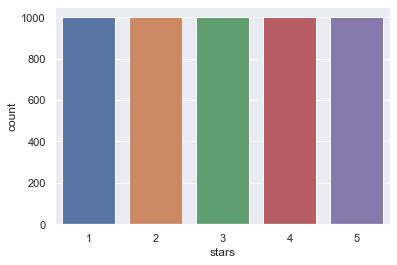

In [6]:
sns.countplot(dataset.stars)
plt.show()

### ¿Qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

Para empezar a analizar el dataset voy a indigar sobre la pregunta "¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?". Esto lo realizare por estrellas, teniendo en cuenta que 1 y 2 estrellas es una calificacion negativa, 4 y 5 son calificaciones positivas y agregare una nueva calificacion que sera estandar que seran aquellas reseñas con 3 estrellas. Lo realizare con el body y con el title para ver cual me brinda mayor informacion

### Comentarios negativos

In [7]:
dataset_negativo = dataset[(dataset.stars == 1) | (dataset.stars == 2)]
dataset_negativo

,stars,review_body,review_title,product_category
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty
...,...,...,...,...
1995,2,"Son muy pequeños,pensé que eran más grandes. N...",Ana Maria,jewelry
1996,2,Es la segunda vez que lo compro. La primera ve...,Capsulas Café,grocery
1997,2,"Tengo que decir que el aparato va bien, pero a...",NO ME HA FUNCIONADO,personal_care_appliances
1998,2,Para bebés nada preciso. No lo recomiendo nada...,No recomendado para bebes,personal_care_appliances


In [8]:
stopwords = nltk.corpus.stopwords.words('spanish')

In [9]:
stopwords.remove('no')
stopwords.remove('ni')

In [10]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
cometarios_negativos = []
for comentario in dataset_negativo.review_body + ', ' + dataset_negativo.review_title:
    comentario = re.sub("[^a-zA-Z]"," ",str(comentario))
    comentario = comentario.replace('á','a')
    comentario = comentario.replace('é','e')
    comentario = comentario.replace('í','i')
    comentario = comentario.replace('ó','o')
    comentario = comentario.replace('ú','u')
    comentario = comentario.replace('ñ','n')
    comentario= comentario.lower()
    comentario=nltk.word_tokenize(comentario)
    comentario = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in comentario]
    comentario = [palabra for palabra in comentario if len(palabra)>1]
    comentario = [word for word in comentario if word not in (stopwords)]
    cometarios_negativos.append(comentario)
cometarios_negativos

[['malisimo',
  'grande',
  'demasiado',
  'aparatoso',
  'mal',
  'protector',
  'pantalla',
  'mala',
  'compra'],
 ['no', 'recibido', 'pedido', 'no', 'devoluci', 'no', 'recibido'],
 ['buscar',
  'sistema',
  'no',
  'funciona',
  'bien',
  'abrazadera',
  'lleva',
  'agarrar',
  'manillar',
  'no',
  'aprieta',
  'bien',
  'deslizando',
  'linterna',
  'hacia',
  'abajo',
  'no',
  'aprieta',
  'bien',
  'manillar'],
 ['utilic',
  'broca',
  'menor',
  'di',
  'metro',
  'doblaron',
  'varias',
  'si',
  'mantequilla',
  'hacer',
  'nima',
  'presi',
  'vez',
  'dobladas',
  'intentar',
  'enderezarlas',
  'parten',
  'exteriormente',
  'amarillas',
  'interior',
  'fundido',
  'gris',
  'peor',
  'compra',
  'hecho',
  'bastante',
  'tiempo',
  'broca',
  'mantequilla'],
 ['no', 'gusta', 'olor', 'viejo', 'aspecto', 'malo', 'no', 'gusta'],
 ['hola',
  'despu',
  'recoger',
  'paquete',
  'llegado',
  'bola',
  'rota',
  'bola',
  'rota'],
 ['parte',
  'no',
  'poder',
  'elegir',
  

In [12]:
cometarios_negativos = list(itertools.chain(*cometarios_negativos))
freq_comentarios_negativos = nltk.FreqDist(cometarios_negativos)
freq_comentarios_negativos

FreqDist({'no': 2863, 'bien': 418, 'calidad': 379, 'producto': 374, 'si': 280, 'ni': 228, 'mal': 196, 'mala': 195, 'do': 181, 'est': 177, ...})

In [13]:
df_cometarios_negativos = pd.DataFrame(list(freq_comentarios_negativos.items()), columns = ["Word","Frequency"])
df_cometarios_negativos.head()

,Word,Frequency
0,malisimo,13
1,grande,51
2,demasiado,97
3,aparatoso,3
4,mal,196


In [14]:
df_cometarios_negativos.sort_values('Frequency',ascending=False, inplace = True)
df_cometarios_negativos.head()

,Word,Frequency
9,no,2863
16,bien,418
87,calidad,379
96,producto,374
33,si,280


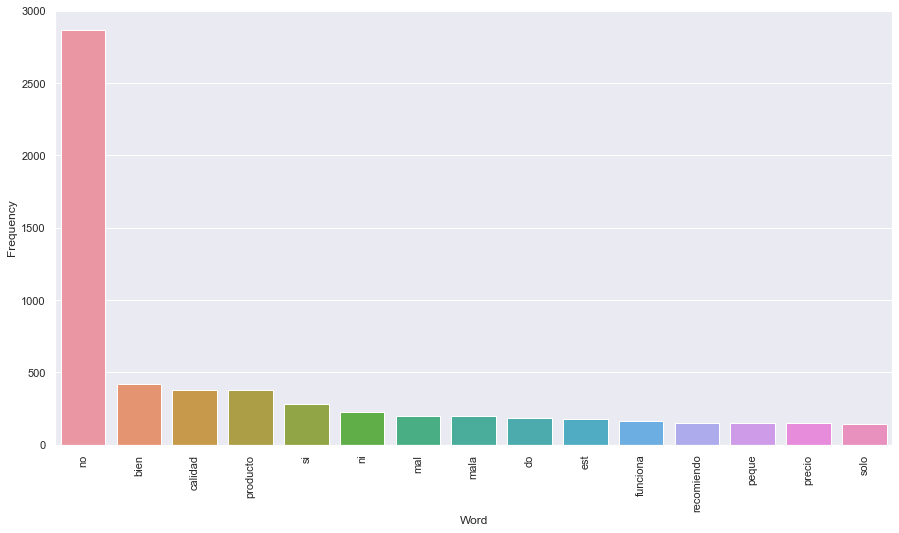

In [15]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_cometarios_negativos.iloc[:15].Word, y = df_cometarios_negativos.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

### Comentario estandar

In [16]:
dataset_estandar = dataset[(dataset.stars == 3)]
dataset_estandar

,stars,review_body,review_title,product_category
2000,3,"Nos gusto por su color, tejido y calidad de es...",Encaja,lawn_and_garden
2001,3,"Ha llegado rápido. , Es más pequeña de lo que ...",Simple.,luggage
2002,3,Me ha gustado el producto,Buen producto,watch
2003,3,"se despega rápido, lo que he hecho ha sido coc...",bien,kitchen
2004,3,no parece tampoco muy especifico para animales...,BASICO,drugstore
...,...,...,...,...
2995,3,Llegó con algunas de las esquinas de las págin...,Rápido,book
2996,3,No le an gustado a los niños es muy gorda,🙀,wireless
2997,3,la calidad de la pantalla no es la mejor se no...,BUENO PARA EL PRECIO,wireless
2998,3,Pensé que podría utilizarlo tanto en el ordena...,Correcto,wireless


In [17]:
cometarios_estandar = []
for comentario in dataset_estandar.review_body + ', ' + dataset_estandar.review_title:
    comentario=comentario.lower()
    comentario = re.sub("[^a-zA-ZñÑáéíóúÁÉÍÓÚ]"," ",str(comentario))
    comentario=nltk.word_tokenize(comentario)
    comentario = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in comentario]
    comentario = [word for word in comentario if word not in (stopwords)]
    comentario = [palabra for palabra in comentario if len(palabra)>1]
    cometarios_estandar.append(comentario)
cometarios_estandar

[['no',
  'gusto',
  'color',
  'tejido',
  'calidad',
  'espuma',
  'recomendable',
  'encaja'],
 ['llegado',
  'rápido',
  'pequeña',
  'pensaba',
  'no',
  'caben',
  'tantas',
  'cosas',
  'cm',
  'foto',
  'material',
  'básico',
  'simple'],
 ['gustado', 'producto', 'buen', 'producto'],
 ['despega', 'rápido', 'hecho', 'sido', 'cocerlo', 'bien'],
 ['no',
  'parece',
  'tampoco',
  'especifico',
  'animales',
  'aprieto',
  'puede',
  'valer',
  'lleva',
  'basico',
  'alguna',
  'cosita',
  'ma',
  'tampoco',
  'ser',
  'mundo',
  'precio',
  'bien',
  'si',
  'buscas',
  'ma',
  'completo',
  'especifico',
  'no',
  'buscas',
  'basico'],
 ['pintar', 'casco', 'lancha', 'destiñe', 'pintar', 'goteaba', 'regulera'],
 ['buenos',
  'única',
  'pega',
  'tapaderas',
  'encajan',
  'bastante',
  'flojas',
  'líquidos',
  'tener',
  'cuidado',
  'buen',
  'material'],
 ['aceptable', 'parte', 'buen', 'servicio', 'rapido'],
 ['ne',
  'entra',
  'caja',
  'interruptor',
  'enchufe',
  'está

In [18]:
cometarios_estandar = list(itertools.chain(*cometarios_estandar))
freq_comentarios_estandar = nltk.FreqDist(cometarios_estandar)
freq_comentarios_estandar

FreqDist({'no': 974, 'bien': 451, 'calidad': 233, 'precio': 194, 'si': 159, 'buena': 110, 'producto': 100, 'mal': 94, 'bastante': 88, 'ma': 76, ...})

In [19]:
df_cometarios_estandar = pd.DataFrame(list(freq_comentarios_estandar.items()), columns = ["Word","Frequency"])
df_cometarios_estandar.head()

,Word,Frequency
0,no,974
1,gusto,13
2,color,34
3,tejido,4
4,calidad,233


In [20]:
df_cometarios_estandar.sort_values('Frequency',ascending=False, inplace = True)
df_cometarios_estandar.head()

,Word,Frequency
0,no,974
27,bien,451
4,calidad,233
42,precio,194
43,si,159


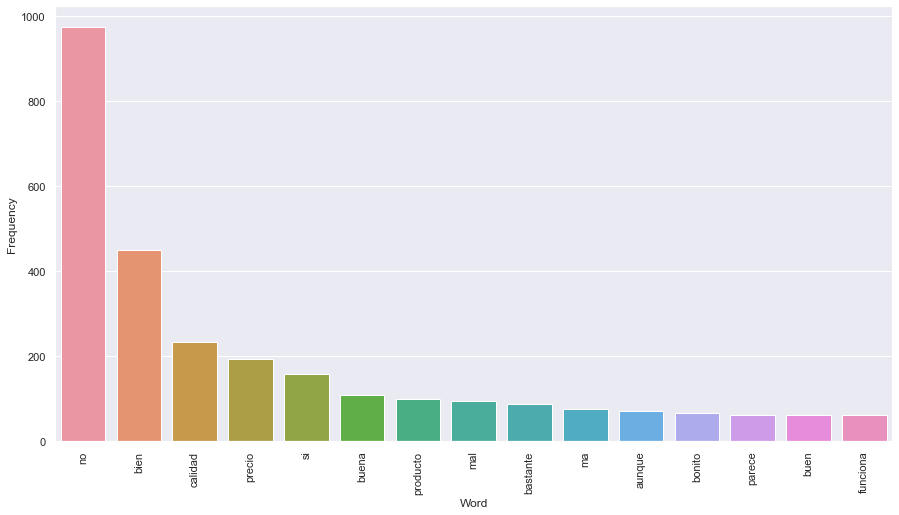

In [21]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_cometarios_estandar.iloc[:15].Word, y = df_cometarios_estandar.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

### Comentario positivo

In [22]:
dataset_positivo = dataset[(dataset.stars == 4) | (dataset.stars == 5)]
dataset_positivo

,stars,review_body,review_title,product_category
3000,4,Son robustas y francamente cumplen con su come...,Gran juego de llaves.,home_improvement
3001,4,Estupenda relación calidad-precio,Funcional,home_improvement
3002,4,Lo compré para mi madre. Esta muy contenta. Es...,compacto y cómodo,furniture
3003,4,"UN POCO ESTRECHO ,PERO VALE PARA LO QUE ES,PAR...",ESTA BIEN,home_improvement
3004,4,Le doy cuatro estrellas porque aún no lo he pr...,Nice.,wireless
...,...,...,...,...
4995,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,home
4996,5,Desempeña su función correctamente,calidad precio,camera
4997,5,Me ha encantado la diadema! Las flores son tal...,Excelente,toy
4998,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,wireless


In [23]:
cometarios_positivo = []
for comentario in dataset_positivo.review_body + ', ' + dataset_positivo.review_title:
    comentario=comentario.lower()
    comentario = re.sub("[^a-zA-ZñÑáéíóúÁÉÍÓÚ]"," ",str(comentario))
    comentario=nltk.word_tokenize(comentario)
    comentario = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in comentario]
    comentario = [word for word in comentario if word not in (stopwords)]
    comentario = [palabra for palabra in comentario if len(palabra)>1]
    cometarios_positivo.append(comentario)
cometarios_positivo

[['robustas',
  'francamente',
  'cumplen',
  'cometido',
  'juego',
  'llaves',
  'necesitaba',
  'contento',
  'compra',
  'gran',
  'juego',
  'llaves'],
 ['estupenda', 'relación', 'calidad', 'precio', 'funcional'],
 ['compré',
  'madre',
  'contenta',
  'compacto',
  'fácil',
  'usar',
  'excepto',
  'necesita',
  'ayuda',
  'bajar',
  'reposapiés',
  'tejido',
  'sencillo',
  'cubierto',
  'plaid',
  'protegerlo',
  'relación',
  'calidad',
  'precio',
  'bien',
  'compacto',
  'cómodo'],
 ['estrecho', 'vale', 'pintura', 'bien'],
 ['doy',
  'cuatro',
  'estrellas',
  'aún',
  'no',
  'probado',
  'días',
  'llevo',
  'walkie',
  'funcionado',
  'perfección',
  'acabado',
  'podría',
  'ser',
  'fino',
  'menos',
  'plástico',
  'precio',
  'no',
  'puede',
  'pedir',
  'nice'],
 ['bien',
  'precios',
  'trae',
  'pack',
  'normales',
  'tirando',
  'finos',
  'calidad',
  'precio'],
 ['no', 'gusta', 'instrucciones', 'ingles', 'bastante', 'completo'],
 ['llego',
  'bien',
  'último

In [24]:
cometarios_positivo = list(itertools.chain(*cometarios_positivo))
freq_comentarios_positivo = nltk.FreqDist(cometarios_positivo)
freq_comentarios_positivo

FreqDist({'no': 878, 'bien': 768, 'calidad': 577, 'buena': 499, 'precio': 473, 'buen': 368, 'producto': 321, 'perfecto': 268, 'compra': 194, 'si': 188, ...})

In [25]:
df_cometarios_positivo = pd.DataFrame(list(freq_comentarios_positivo.items()), columns = ["Word","Frequency"])
df_cometarios_positivo.head()

,Word,Frequency
0,robustas,1
1,francamente,1
2,cumplen,18
3,cometido,25
4,juego,26


In [26]:
df_cometarios_positivo.sort_values('Frequency',ascending=False, inplace = True)
df_cometarios_positivo.head()

,Word,Frequency
40,no,878
31,bien,768
12,calidad,577
77,buena,499
13,precio,473


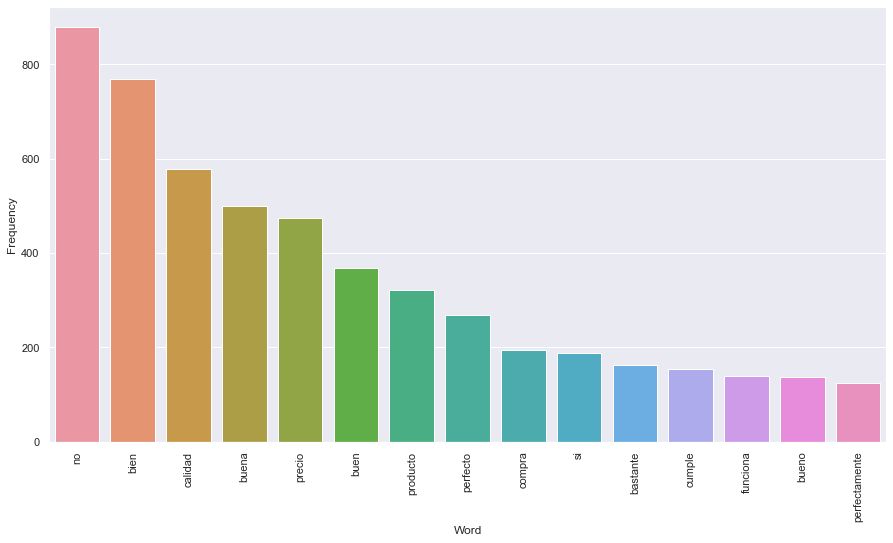

In [27]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_cometarios_positivo.iloc[:15].Word, y = df_cometarios_positivo.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

#### Conclusion

Resumiendo:
* negativos: no, bien, calidad, producto, si, ni mal, mala, funciona. 
* estandar: no, bien, calidad, precio, si,buena, producto, mal, bastante. 
* positivos: no, bien, calidad,buena, precio,buen, producto, perfecto, si, compra.  <br>
 <br>
Luego de observar esta lista vemos que las 3 primeras palabras que mas aparecen en cada categoria son las misma por lo tanto no son utiles para definir una categoria. Podriamos utilizar las palabras con menor frecuencia pero que son unicas para la categoria:  <br>
<br>
* negativos: ni, mal, mala, funciona
* estandar: si, buena, producto, bastante
* positivos: buena, precio, buen, perfecto, si, compra.   <br>
 <br>
Hay una tendencia a que los comentarios estandar se parezcan mas a los comentarios positivos que los negativos.

### ¿Según el tipo de producto podemos ver una tendencia en la asignacion de estrellas?

1 Estrellas


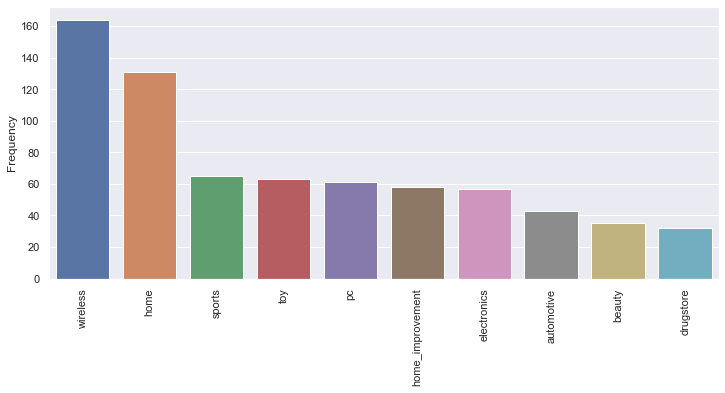

2 Estrellas


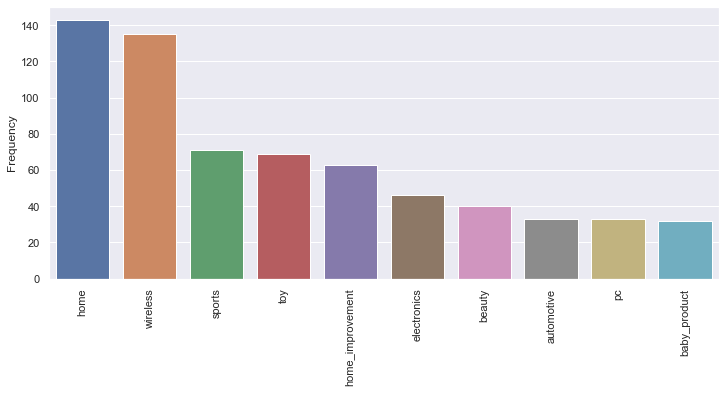

3 Estrellas


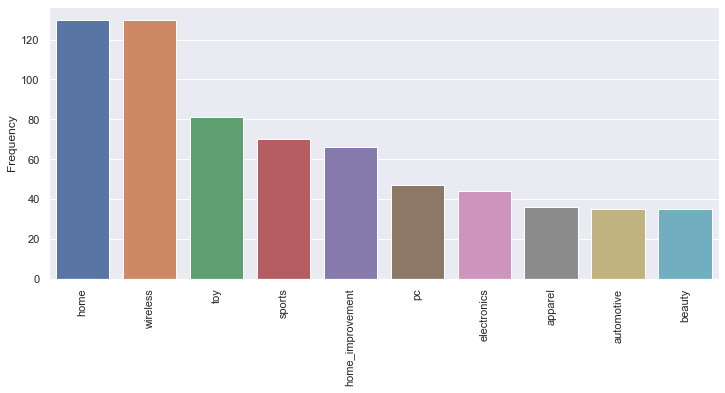

4 Estrellas


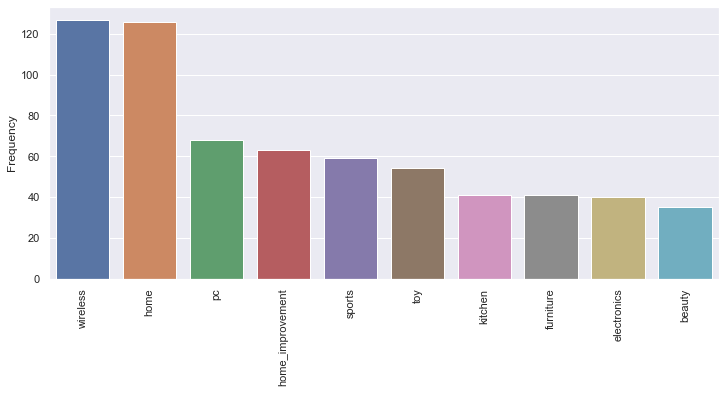

5 Estrellas


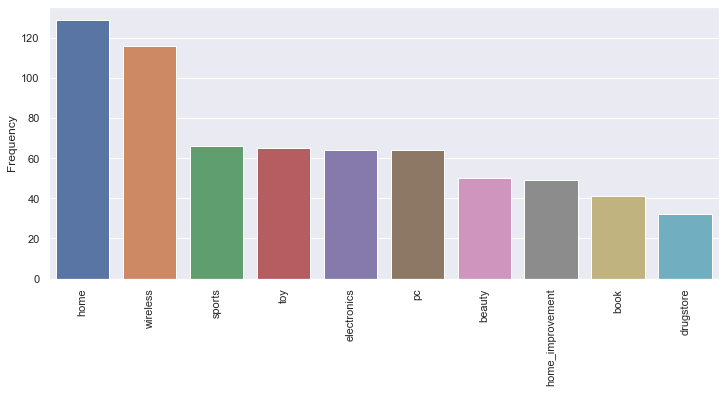

In [73]:

for i in range(5):
    print(i+1, 'Estrellas')
    serie_productCat = (dataset[dataset.stars == i+1].product_category.value_counts())
    ds_productCat = serie_productCat.to_frame()
    ds_productCat.columns = ['Frequency']
    plt.figure(figsize = (12,5))
    plot = sns.barplot(x  = ds_productCat.iloc[:10].index, y = ds_productCat.iloc[:10].Frequency)
    for item in plot.get_xticklabels():
        item.set_rotation(90)
    plt.show()

Luego de observar los graficos vemos que no hay ninguna de tipo de producto por cantidad de estrellas, ya que se repiten mucho los primeros y segundos puestos, esto quizas se deba a que son los tipos de productos mas vendidos. Al haber mas productos vendidos de un producto es mas probables que reciba valoraciones mas distintas a uno que es menos vendido

Voy a eliminar esta columna ya que no nos brindara mucha informacion util

In [76]:
dataset.drop(columns=['product_category'], inplace=True)

### Imputacion de valores faltantes

In [78]:
datosNull = dataset.isna().sum()
datosNull

stars           0
review_body     0
review_title    0
dtype: int64

### Normalizacion y Stemming

In [79]:
dataset.head()

,stars,review_body,review_title
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra
1,1,No he recibido el pedido no la devolución,No lo he recibido
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta


In [80]:
review_stem_list=[]
for i in dataset.review_body + ', ' + dataset.review_title:
    comentario= re.sub("[^a-zA-ZñÑáéíóúÁÉÍÓÚ]"," ",str(i))
    comentario= comentario.lower()
    comentario=nltk.word_tokenize(comentario)
    #comentario = [palabra for palabra in comentario if len(palabra)>2]
    comentario = [palabra for palabra in comentario if not palabra in stopwords]
    comentario=[stemmer.stem(palabra) for palabra in comentario]
    
    comentario=" ".join(comentario)
    review_stem_list.append(comentario)
review_stem_list

['malisim grand demasi aparat mal protector pantall mal compr',
 'no recib ped no devolu no recib',
 'busc sistem no funcion bien abrazader llev agarr manill no apriet bien desliz lintern haci abaj no apriet bien manill',
 'utilic broc menor diametr dobl vari si mantequill hac minim presion vez dobl intent enderez part exterior amarill interior fund gris peor compr hech bastant tiemp broc mantequill',
 'no gust olor viej aspect mal no gust',
 'hol despues recog paquet lleg bol rot bol rot',
 'part no pod eleg color envi cest color asa imagin aprovech van romp dic color aleatori fot cest asa mism color recom compr pued eleg color unic alivi romp pront calid no alla part no pod eleg color',
 'baj calid ahi si preci compr supon tir diner tap pantall',
 'product sal entreg no recib no recib product',
 'no recom no peg acab despeg patat',
 'desliz haci abaj rat hech material baj calid no recom desliz haci abaj rat',
 'dos mes despues no lleg amazon no deb convert mercadill vendedor chin no 

In [81]:
dataset["review_stem"] = review_stem_list
dataset.head()

,stars,review_body,review_title,review_stem
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,malisim grand demasi aparat mal protector pant...
1,1,No he recibido el pedido no la devolución,No lo he recibido,no recib ped no devolu no recib
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,busc sistem no funcion bien abrazader llev aga...
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,utilic broc menor diametr dobl vari si mantequ...
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,no gust olor viej aspect mal no gust


### Lemmatizacion

In [19]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [20]:
review_lemm_list=[]
for review in dataset.review_body + ', ' + dataset.review_title:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    # Pasamos todo a minúsculas
    review=review.lower()
    review=review.replace('á','a')
    review=review.replace('é','e')
    review=review.replace('í','i')
    review=review.replace('ó','o')
    review=review.replace('ú','u')
    review =re.sub("[^a-zA-Z]"," ",str(review))
    # Tokenizamos para separar las palabras
    review=nltk.word_tokenize(review)
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    review = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in review]
    # Eliminamos las palabras d emenos de 3 letras
    review = [palabra for palabra in review if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    #dataset["titular_normalizado"] = titular_list
    review_lemm_list.append(review)

In [21]:
dataset["review_lemm"] = review_lemm_list
dataset.tail()

,stars,review_body,review_title,product_category,review_stem,review_lemm
4995,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,home,encantado cesta llegado impec tamaño util pesa...,encantado cesta llegado impecable tama util pe...
4996,5,Desempeña su función correctamente,calidad precio,camera,desempeña función correctament calidad precio,desempe funcion correctamente calidad precio
4997,5,Me ha encantado la diadema! Las flores son tal...,Excelente,toy,encantado diadema flore tal vienen imagen vení...,encantado diadema flores vienen imagen venian ...
4998,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,wireless,gustan funda tpu funda normalment fina colorid...,gustan fundas fundas normalmente finas colorid...
4999,5,El artículo ha cumplido con las expectativas q...,Buena calidad,apparel,artículo cumplido expectativa deseaba buena ca...,articulo cumplido expectativas deseaba buena c...


A partir de aca utilizare los datos obtenidos con la lemmatizacion ya que por algunos detalles me parece que fue mas optima que la stemmizacion

### Vectorizar

In [82]:
max_features=1000
cou_vec=CountVectorizer(max_features=max_features, ngram_range=(1,4))

Decidi utilizar stemming ya que me trajo mejores resultados

In [83]:
matriz_review = cou_vec.fit_transform(review_stem_list)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("Primeras 50 palabras: ",all_words[0:50])

Primeras 50 palabras:  ['abaj', 'abiert', 'abre', 'abrir', 'abrirl', 'absolut', 'acab', 'accesori', 'aceit', 'acept', 'aconsej', 'acopl', 'adapt', 'adapt bien', 'adecu', 'adem', 'ademas', 'agarr', 'agrad', 'agu', 'aguant', 'agujer', 'ahi', 'ahor', 'ahor no', 'ahorr', 'air', 'ajust', 'ajust bien', 'algui', 'algun', 'aliment', 'alta', 'altavoz', 'alto', 'altur', 'alumbr', 'amarill', 'amazon', 'amazon no', 'ampli', 'ancho', 'anten', 'anterior', 'anunci', 'apag', 'aparat', 'aparec', 'apart', 'apen']


### Machine learning

A continuación desarrollare algunos modelos de ML para poder predecir las estrellas a traves de la información que tengo. Estos modelos seran de clasificacion ya que contamos con 5 opciones posibles, podria ser de regresión si se pudiese poner 3,3 estrellas o 2,6 o 4,5 ya que en ese caso los valores serian infinitos.

Las metricas elegidas son precision, recall, f1-score y accuracy porque nos encontramos con un modelo de clasificacion, toma mas de una metrica ya que nos brinda mas informacion. Tambien realizare una matriz de confusion para observar mejor los resultados.

Defino una funcion para poder reutilizar con cada modelo y realizar la matriz de confusion

In [86]:
def confusion(ytest,y_pred):
    names=["1 estrella","2 estrellas","3 estrellas","4 estrellas","5 estrellas"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.setp(plt.xticks()[1], rotation=60)
    plt.setp(plt.yticks()[1], rotation=0)
    plt.show()

    return

Tomare como X las columnas 'review_body' y 'review_title', por otro lado tomare como y las estrellas asignadas.

In [87]:
X = matriz_review.toarray()
y = dataset['stars']

In [88]:
len(X)

5000

Divido en train y test

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3500, 1000) (3500,) (1500, 1000) (1500,)


#### Benchmark - Naive Bayes

In [91]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB()

In [92]:
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

In [93]:
print('Metricas en test:','\n',classification_report(y_test,y_test_pred))

Metricas en test: 
               precision    recall  f1-score   support

           1       0.46      0.61      0.53       300
           2       0.39      0.17      0.24       300
           3       0.30      0.09      0.14       300
           4       0.31      0.18      0.23       300
           5       0.35      0.82      0.49       300

    accuracy                           0.38      1500
   macro avg       0.36      0.38      0.33      1500
weighted avg       0.36      0.38      0.33      1500



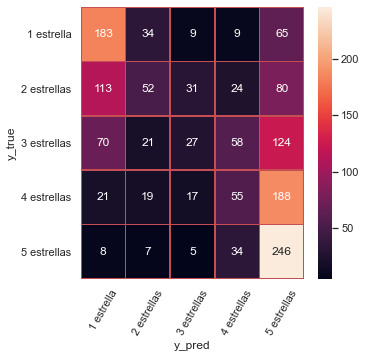

In [94]:
confusion(y_test,y_test_pred)

Los valores son bajos, al ser el benchmark de cierta forma era lo esperado.

#### KNN

In [96]:
knn = KNeighborsClassifier(n_neighbors=10) 

In [97]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [98]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

In [99]:
print('Metricas en test:','\n',classification_report(y_test,y_test_pred))

Metricas en test: 
               precision    recall  f1-score   support

           1       0.50      0.55      0.53       300
           2       0.31      0.26      0.28       300
           3       0.30      0.19      0.23       300
           4       0.33      0.26      0.29       300
           5       0.37      0.61      0.46       300

    accuracy                           0.37      1500
   macro avg       0.36      0.37      0.36      1500
weighted avg       0.36      0.37      0.36      1500



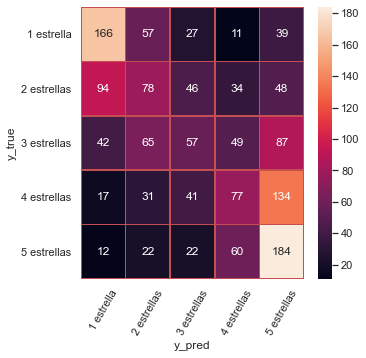

In [100]:
confusion(y_test,y_test_pred)

Podemos ver que los valores mejoran un poco con respecto al benchmark

#### Random forest

In [102]:
rf = RandomForestClassifier(n_estimators = 200, random_state=42)
rf.fit(X_train,y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [103]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [104]:
print('Metricas en test:','\n',classification_report(y_test,y_test_pred))

Metricas en test: 
               precision    recall  f1-score   support

           1       0.55      0.70      0.62       300
           2       0.35      0.29      0.32       300
           3       0.38      0.35      0.37       300
           4       0.41      0.26      0.32       300
           5       0.48      0.63      0.55       300

    accuracy                           0.45      1500
   macro avg       0.43      0.45      0.43      1500
weighted avg       0.43      0.45      0.43      1500



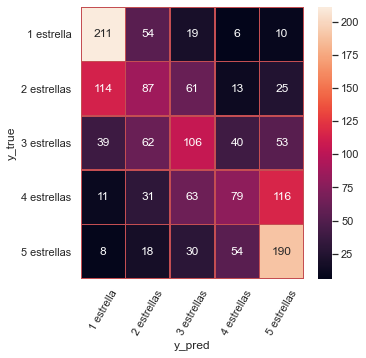

In [105]:
confusion(y_test,y_test_pred)

Aumenta en buena medida a los modelos anteriores.

##### Optimizacion de hiperparametros

In [111]:
param_grid = {'max_features':['auto', 'sqrt', 'log2'] , 
              'max_depth':np.arange(2,7) ,
              }

In [112]:
model_randomForest_clas = RandomizedSearchCV(rf, param_grid,n_iter=10, random_state=0, cv=5)

In [114]:
model_randomForest_clas.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=200,
                                                    random_state=42),
                   param_distributions={'max_depth': array([2, 3, 4, 5, 6]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2']},
                   random_state=0)

In [116]:
print("Mejores parametros: "+str(model_randomForest_clas.best_params_))
print("Mejor Score: "+str(model_randomForest_clas.best_score_)+'\n')

Mejores parametros: {'max_features': 'log2', 'max_depth': 6}
Mejor Score: 0.46085714285714285



##### Evaluo el modelo con los mejores parametros

In [117]:
rf = RandomForestClassifier(n_estimators = 200, random_state=42,max_features='log2', max_depth= 6)
rf.fit(X_train,y_train)


RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=200,
                       random_state=42)

In [118]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [119]:
print('Metricas en test:','\n',classification_report(y_test,y_test_pred))

Metricas en test: 
               precision    recall  f1-score   support

           1       0.54      0.69      0.61       300
           2       0.37      0.28      0.32       300
           3       0.37      0.28      0.32       300
           4       0.40      0.28      0.33       300
           5       0.44      0.66      0.52       300

    accuracy                           0.44      1500
   macro avg       0.42      0.44      0.42      1500
weighted avg       0.42      0.44      0.42      1500



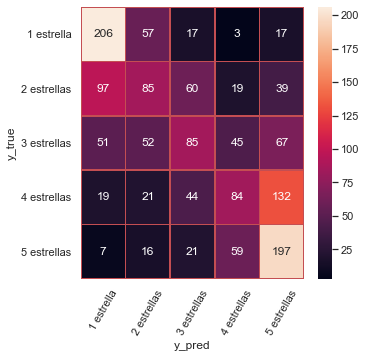

In [120]:
confusion(y_test,y_test_pred)

#### SVM

In [107]:
svc = LinearSVC(C = 1)
svc.fit(X_train,y_train)

C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1)

In [108]:
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

In [109]:
print('Metricas en test:','\n',classification_report(y_test,y_test_pred))

Metricas en test: 
               precision    recall  f1-score   support

           1       0.54      0.55      0.54       300
           2       0.34      0.33      0.33       300
           3       0.32      0.32      0.32       300
           4       0.35      0.35      0.35       300
           5       0.51      0.54      0.53       300

    accuracy                           0.42      1500
   macro avg       0.41      0.42      0.42      1500
weighted avg       0.41      0.42      0.42      1500



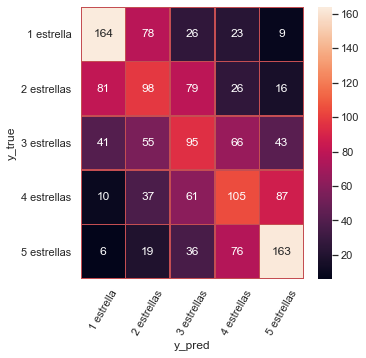

In [110]:
confusion(y_test,y_test_pred)

##### Optimizacion de hiperparametros

In [126]:
param_grid = {'random_state':[10,100,200,250] , 
              'C':np.arange(2,7) ,
              }

In [127]:
model_svm_clas = RandomizedSearchCV(svc, param_grid,n_iter=10, random_state=0, cv=5)

In [128]:
model_svm_clas.fit(X_train, y_train)

C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\sklearn\s

RandomizedSearchCV(cv=5, estimator=LinearSVC(C=1),
                   param_distributions={'C': array([2, 3, 4, 5, 6]),
                                        'random_state': [10, 100, 200, 250]},
                   random_state=0)

In [129]:
print("Mejores parametros: "+str(model_svm_clas.best_params_))
print("Mejor Score: "+str(model_svm_clas.best_score_)+'\n')

Mejores parametros: {'random_state': 100, 'C': 2}
Mejor Score: 0.4045714285714285



##### Evaluo el modelo con los mejores parametros

In [131]:
svc = LinearSVC(C = 2,random_state=100)
svc.fit(X_train,y_train)

C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=2, random_state=100)

In [132]:
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

In [133]:
print('Metricas en test:','\n',classification_report(y_test,y_test_pred))

Metricas en test: 
               precision    recall  f1-score   support

           1       0.53      0.54      0.54       300
           2       0.33      0.31      0.32       300
           3       0.31      0.32      0.32       300
           4       0.35      0.35      0.35       300
           5       0.50      0.51      0.51       300

    accuracy                           0.41      1500
   macro avg       0.40      0.41      0.41      1500
weighted avg       0.40      0.41      0.41      1500



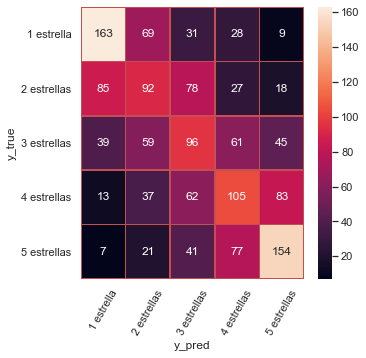

In [134]:
confusion(y_test,y_test_pred)

El modelo no mejora mucho luego de hacer optimizacion de hiperparametros

### Conclusion

Luego de poder analizar los distintos modelos llego a la conclusion que el mejor es randomforest, aunque por muy poco con respecto a svm. Podemos ver en todos los modelos que tiene mas aciertos en los que son de 1 y 5 estrellas, esto se debe a que son los extremos por lo tanto es mas determinista. Luego observamos que en 2 y 4 estrellas predice un poco mejor que en 3 estrellas, creo que era esperable ya que 3 estrellas es el punto medio y un poco ambiguo pudiendo ser un comentario muy parecido a uno de 2 o 4 estrellas.  <br>
Creo que lo importante para el modelo es la distancia entre palabras, ya que no es lo mismo "No me gusto" a "No puedo creer que buen producto es", en ambas se utilizan las mismas palabras pero tienen significados totalmente distintos, el modelo se debe encargar de ver a traves de la distancia de las palabras e identificar si es un comentario bueno o malo. Es una tarea sumamente dificil ya que en las recomendaciones se usan muchas palabras iguales para cada estrella. <br>
Es notorio que los resultados de las metricas que tome son bajas. Si bien logra mejorar al benchmark tomado sigue siendo bajo. Quizas para mejorar esto podria utilizar el dataset con mas cantidad de datos, ya que podria entrenar mejor el modelo. Por otro lado, tambien podria probar con la libreria spacy que por algunos articulos que lei trabaja mejor con el idioma español.

## Para pensar e investigar

Creo que si se convierte en un problema binario donde se predicen comentarios negativos y positivos se obtendran mejores resultados parciales, es decir que en metricas lo mas probable es que aumenten pero se perdera informacion valiosa de que tan negativo o positivo le parecio. Por ejemplo, el valor 3 es un gris, donde no se sabria si es negativo o positivo, por lo tanto convertirlo en una problema binario creo que haria que este valor intermedio se pierda. Quizas se podria convertir en un problema de 3 estrellas en vez de 5. <br>
 <br>
Ademas, en este caso particular, no veo conveniente pasarlo a un problema binario porque un producto no necesariamente es malisimo o perfecto puede haber valores intermedios y que sean interesantes para otros usuarios tenerlos en cuenta. Quizas se podria utilizar las etiquetas lo recomiendo o no lo recomiendo, teniendo en cuenta los comentarios, es decir agregar otra informacion para brindar al usuario y poder predecir esta de forma binaria. <br>
 <br>
Por otro lado, lo que me gustaria probar seria convertirlo a un problema de regresion, donde se pregunte que tan bueno es el producto, y que devuelva un valor (que puede ser decimal), y ese valor se convierta en un porcentaje de cuanto le gusto al usuario el producto, siendo 0 lo mas bajo y 100 lo mas alto. Quizas asi se puede llegar a un valor mas preciso y no tan estandarizado como colocar una cierta cantidad de estrellas. 